## Se selecciona la época 6, correspondiente al punto donde el modelo alcanza su mejor desempeño en la predicción de violencia en videos. Para ello, se carga el archivo model_checkpoint_ef_epoch_test_6.pth, el cual registra la mayor precisión en el conjunto de prueba (Test Accuracy: 0.8889)

In [1]:
# -------------------------------
# MÓDULOS DE PYTHON ESTÁNDAR / UTILIDADES
# -------------------------------

# Manejo del sistema de archivos y rutas
import os
# Manejo de advertencias (warnings)
import warnings
# Recolección de basura manual (liberar memoria)
import gc

# -------------------------------
# VISUALIZACIÓN Y DISPLAY
# -------------------------------

# Visualización de gráficos
import matplotlib.pyplot as plt
# Visualización de mapas de calor y análisis con seaborn
import seaborn as sns
# Mostrar elementos en Jupyter como tablas o imágenes
from IPython.display import display

# -------------------------------
# MANEJO DE DATOS
# -------------------------------

# Manipulación de datos tabulares
import pandas as pd
# Cálculos numéricos eficientes
import numpy as np

# -------------------------------
# VISIÓN POR COMPUTADOR
# -------------------------------

# OpenCV para leer y procesar imágenes o videos
import cv2

# -------------------------------
# PYTORCH
# -------------------------------

# Librería principal de PyTorch
import torch
# Submódulo para definir redes neuronales
from torch import nn
# Dataset y DataLoader para cargar datos
from torch.utils.data import DataLoader, Dataset
# Transformaciones de imágenes (normalización, conversión a tensor, etc.)
from torchvision import transforms

# -------------------------------
# MÉTRICAS
# -------------------------------

# Métricas de evaluación para clasificación
from sklearn.metrics import confusion_matrix, classification_report

# -------------------------------
# CONFIGURACIÓN GLOBAL
# -------------------------------

# Ignorar todos los warnings para evitar mensajes molestos en consola
warnings.filterwarnings("ignore")

In [2]:
# Modelo mejorado basado en una red neuronal convolucional 3D
class Improved3DCNN(nn.Module):
    # Constructor del modelo
    def __init__(self):
        # Llama al constructor de la clase base nn.Module
        super(Improved3DCNN, self).__init__()

        # Primera capa convolucional 3D: entrada de 3 canales (RGB), salida de 16
        self.conv1 = nn.Conv3d(3, 16, kernel_size=(3, 3, 3), padding=1)
        # Dropout para regularización después de la primera convolución
        self.dropout1 = nn.Dropout(0.2)
        # MaxPooling 3D que reduce las dimensiones espaciales (alto y ancho)
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2))

        # Segunda capa convolucional: de 16 a 32 canales
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=1)
        # Dropout después de la segunda convolución
        self.dropout2 = nn.Dropout(0.2)

        # Tercera capa convolucional: de 32 a 64 canales
        self.conv3 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=1)
        # Dropout después de la tercera convolución
        self.dropout3 = nn.Dropout(0.2)

        # Calcula automáticamente el tamaño que debe tener la primera capa fully connected
        self.fc_input_size = self._get_fc_input_size()

        # Primera capa completamente conectada: de fc_input_size a 128 neuronas
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        # Dropout en la capa densa para reducir overfitting
        self.dropout_fc = nn.Dropout(0.2)
        # Capa de salida: 2 neuronas (para clasificación binaria: violencia o no violencia)
        self.fc2 = nn.Linear(128, 2)

    # Método auxiliar para calcular dinámicamente el tamaño de entrada a la capa fc1
    def _get_fc_input_size(self):
        with torch.no_grad():  # No se calculan gradientes en este bloque
            # Simula un lote con una muestra, 3 canales, 30 frames de 224x224 píxeles
            x = torch.zeros(1, 3, 30, 224, 224)
            # Aplica conv1 + ReLU + pool
            x = self.pool(nn.functional.relu(self.conv1(x)))
            # Aplica conv2 + ReLU + pool
            x = self.pool(nn.functional.relu(self.conv2(x)))
            # Aplica conv3 + ReLU + pool
            x = self.pool(nn.functional.relu(self.conv3(x)))
            # Devuelve el número total de elementos como tamaño de entrada
            return x.numel()

    # Método de propagación hacia adelante del modelo
    def forward(self, x):
        # Primera capa: convolución + ReLU + pooling + dropout
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.dropout1(x)

        # Segunda capa: convolución + ReLU + pooling + dropout
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.dropout2(x)

        # Tercera capa: convolución + ReLU + pooling + dropout
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.dropout3(x)

        # Aplanar el tensor para pasarlo a las capas completamente conectadas
        x = x.view(-1, self.fc_input_size)

        # Capa densa + ReLU + dropout
        x = self.dropout_fc(nn.functional.relu(self.fc1(x)))

        # Capa de salida sin activación (se usará CrossEntropyLoss que incluye Softmax internamente)
        x = self.fc2(x)

        # Retorna la salida final del modelo
        return x  
    
# -----------------------------------------------------------
# Función para predecir la clase (violencia o no violencia) en nuevos videos
# -----------------------------------------------------------
def predict_new_videos(directory, model, transform, device):
    # Coloca el modelo en modo evaluación (desactiva dropout, batchnorm, etc.)
    model.eval()

    # Itera sobre todos los archivos del directorio especificado
    for video_file in os.listdir(directory):
        # Solo considera archivos con extensión .mp4
        if video_file.endswith('.mp4'):
            # Construye la ruta completa del video
            video_path = os.path.join(directory, video_file)

            # Abre el video con OpenCV
            cap = cv2.VideoCapture(video_path)
            frames = []  # Lista para almacenar los frames extraídos

            # Leer todos los frames del video
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break  # Si no hay más frames, salir del bucle

                # Redimensionar cada frame a 224x224 píxeles
                frame = cv2.resize(frame, (224, 224))

                # Aplicar transformaciones si están definidas (ToTensor + Normalize)
                if transform:
                    frame = transform(frame)

                # Agregar el frame transformado a la lista
                frames.append(frame)

            # Cerrar el video
            cap.release()

            # Asegurar que el video tenga exactamente 30 frames
            if len(frames) < 30:
                # Si hay menos de 30, rellenar con tensores de ceros
                frames += [torch.zeros(3, 224, 224)] * (30 - len(frames))
            # Si hay más de 30, recortar los primeros 30
            frames = frames[:30]

            # Convertir la lista de frames en un solo tensor: [T, C, H, W] → [C, T, H, W]
            frames = torch.stack(frames).permute(1, 0, 2, 3)
            # Añadir dimensión de batch y mover al dispositivo (GPU o CPU)
            frames = frames.unsqueeze(0).to(device)

            # Hacer predicción sin calcular gradientes
            with torch.no_grad():
                # Obtener la salida del modelo
                output = model(frames)
                # Obtener la clase con mayor probabilidad
                _, predicted = torch.max(output.data, 1)

                # Imprimir resultado con nombre del archivo y predicción
                print(f'Video: {video_file}, Predicted: {"Violence" if predicted.item() == 1 else "NonViolence"}')


# -----------------------------------------------------------
# Transformaciones aplicadas a cada frame antes de la predicción
# -----------------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),  # Convierte imágenes en tensores [C, H, W]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normaliza a rango [-1, 1]
])

# -----------------------------------------------------------
# Inicialización del dispositivo de cómputo (GPU si está disponible, si no CPU)
# -----------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------------------
# Cargar el modelo mejorado y moverlo al dispositivo (para inferencia)
# -----------------------------------------------------------
model = Improved3DCNN().to(device)

## Matriz de confusión y métricas

Train Metrics:
Classification Report:


,precision,recall,f1-score,support
0,0.86,0.97,0.91,106
1,0.97,0.84,0.90,106
accuracy,0.91,0.91,0.91,1
macro avg,0.91,0.91,0.91,212
weighted avg,0.91,0.91,0.91,212


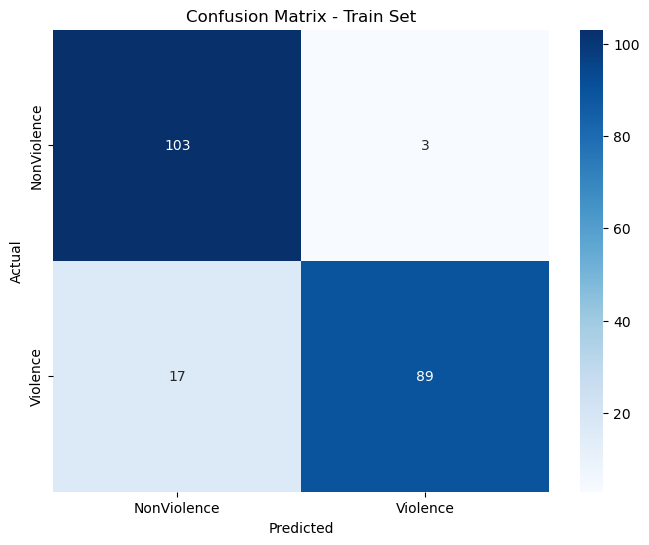

Test Metrics:
Classification Report:


,precision,recall,f1-score,support
0,0.89,0.89,0.89,27
1,0.89,0.89,0.89,27
accuracy,0.89,0.89,0.89,1
macro avg,0.89,0.89,0.89,54
weighted avg,0.89,0.89,0.89,54


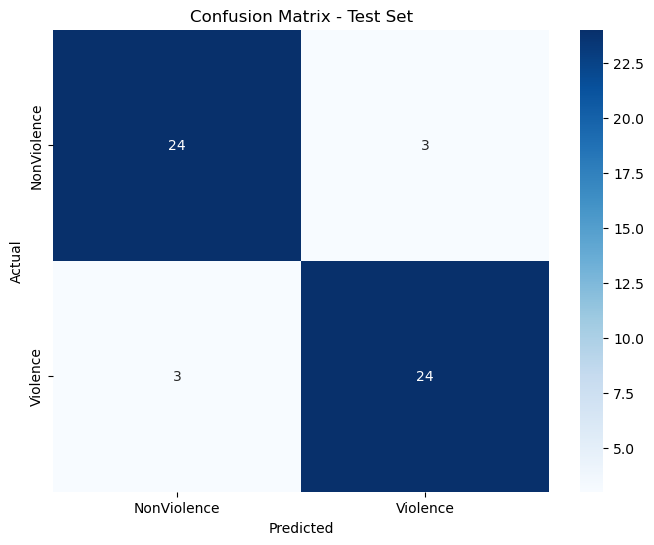

In [3]:
# -----------------------------------------------------------
# Clase personalizada para cargar videos desde carpetas etiquetadas
# -----------------------------------------------------------
class VideoDataset(Dataset):
    # Constructor de la clase. Recibe el directorio base y transformaciones opcionales
    def __init__(self, directory, transform=None):
        self.directory = directory  # Ruta al directorio de datos
        self.transform = transform  # Transformaciones opcionales para los frames
        self.videos = []  # Lista para almacenar las rutas de los videos
        self.labels = []  # Lista para almacenar las etiquetas (1 para 'Violence', 0 para 'NonViolence')

        # Recorre las subcarpetas 'Violence' y 'NonViolence' dentro del directorio
        for label in ['Violence', 'NonViolence']:
            path = os.path.join(self.directory, label)  # Ruta a la subcarpeta correspondiente
            for video_file in os.listdir(path):  # Itera sobre todos los archivos del directorio
                if video_file.endswith('.mp4'):  # Solo procesa archivos .mp4
                    self.videos.append(os.path.join(path, video_file))  # Guarda ruta completa del video
                    self.labels.append(1 if label == 'Violence' else 0)  # Asigna etiqueta binaria según clase

    # Devuelve la cantidad total de videos en el dataset
    def __len__(self):
        return len(self.videos)

    # Devuelve un video procesado (como tensor) y su etiqueta, dado un índice
    def __getitem__(self, idx):
        video_path = self.videos[idx]  # Ruta del video actual
        label = self.labels[idx]       # Etiqueta correspondiente

        # Abre el video usando OpenCV
        cap = cv2.VideoCapture(video_path)
        frames = []  # Lista para almacenar los frames extraídos

        # Lee todos los frames del video
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            # Redimensiona el frame a 224x224 píxeles
            frame = cv2.resize(frame, (224, 224))
            # Aplica las transformaciones (ToTensor, Normalize, etc.)
            if self.transform:
                frame = self.transform(frame)
            # Agrega el frame a la lista
            frames.append(frame)

        # Cierra el archivo de video
        cap.release()

        # Si hay menos de 30 frames, rellena con tensores de ceros
        if len(frames) < 30:
            frames += [torch.zeros(3, 224, 224)] * (30 - len(frames))

        # Si hay más de 30, se queda solo con los primeros 30
        frames = frames[:30]

        # Convierte la lista de frames a un tensor de forma [T, C, H, W]
        frames = torch.stack(frames)

        # Cambia la forma del tensor a [C, T, H, W] para CNN 3D
        frames = frames.permute(1, 0, 2, 3)

        # Retorna los frames procesados y su etiqueta correspondiente
        return frames, label

# -----------------------------------------------------------
# Inicialización del modelo y selección del dispositivo
# -----------------------------------------------------------
# Define si se usará GPU (si está disponible) o CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crea una instancia del modelo mejorado y lo mueve al dispositivo
model = Improved3DCNN().to(device)

# -----------------------------------------------------------
# Carga del checkpoint previamente entrenado
# -----------------------------------------------------------
# Carga el archivo del checkpoint guardado en la época 6
checkpoint = torch.load('/home/michell-alvarez/e_modelos/EF/model_checkpoint_ef_epoch_test_6.pth')

# Restaura los pesos del modelo con el estado guardado
model.load_state_dict(checkpoint['model_state_dict'])

# -----------------------------------------------------------
# Directorios de los conjuntos de datos
# -----------------------------------------------------------
# Ruta del conjunto de entrenamiento
train_dir = '/home/michell-alvarez/e_modelos/EF/Violencia/Train'

# Ruta del conjunto de prueba
test_dir = '/home/michell-alvarez/e_modelos/EF/Violencia/Test'

# -----------------------------------------------------------
# Transformaciones para los datos de entrada
# -----------------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),  # Convierte los frames a tensores [C, H, W]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normaliza los valores de píxel a rango [-1, 1]
])

# -----------------------------------------------------------
# Creación de los datasets y DataLoaders para entrenamiento y prueba
# -----------------------------------------------------------

# Crea el dataset de entrenamiento aplicando las transformaciones definidas
train_dataset = VideoDataset(train_dir, transform)

# Crea el dataset de prueba con las mismas transformaciones
test_dataset = VideoDataset(test_dir, transform)

# Crea el DataLoader para entrenamiento, con shuffle activado y uso eficiente de memoria con pin_memory
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)

# Crea el DataLoader para prueba, sin barajar los datos
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=True)

# -----------------------------------------------------------
# Función para evaluar el modelo y devolver etiquetas reales y predichas
# -----------------------------------------------------------
def evaluate(loader, model, device):
    y_true = []  # Lista para etiquetas verdaderas
    y_pred = []  # Lista para etiquetas predichas
    model.eval()  # Pone el modelo en modo evaluación (desactiva dropout, batchnorm, etc.)

    # Desactiva el cálculo de gradientes para mejorar el rendimiento
    with torch.no_grad():
        # Itera sobre los lotes del DataLoader
        for inputs, labels in loader:
            # Mueve los datos al dispositivo (GPU o CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            # Predicción del modelo
            outputs = model(inputs)
            # Obtiene el índice de la clase con mayor puntuación
            _, predicted = torch.max(outputs.data, 1)
            # Convierte las etiquetas reales y predichas a listas en la CPU
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Devuelve arrays numpy con las etiquetas reales y predichas
    return np.array(y_true), np.array(y_pred)

# -----------------------------------------------------------
# Ejecuta la evaluación del modelo en los conjuntos de entrenamiento y prueba
# -----------------------------------------------------------

# Etiquetas reales y predichas del conjunto de entrenamiento
train_y_true, train_y_pred = evaluate(train_loader, model, device)

# Etiquetas reales y predichas del conjunto de prueba
test_y_true, test_y_pred = evaluate(test_loader, model, device)

# -----------------------------------------------------------
# Función para mostrar un reporte de métricas con estilo
# -----------------------------------------------------------
def print_metrics(y_true, y_pred):
    # Calcula el reporte de clasificación como diccionario
    report = classification_report(y_true, y_pred, output_dict=True)

    # Convierte el diccionario en un DataFrame para visualización
    report_df = pd.DataFrame(report).transpose()

    # Aplica estilo con fondo en gradiente azul y formato decimal
    styled_report = report_df.style.background_gradient(cmap='Blues').format({
        'precision': '{:.2f}',
        'recall': '{:.2f}',
        'f1-score': '{:.2f}',
        'support': '{:.0f}'
    })

    # Muestra el informe de clasificación estilizado
    print("Classification Report:")
    display(styled_report)

# -----------------------------------------------------------
# Función para graficar la matriz de confusión
# -----------------------------------------------------------
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    # Calcula la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Define tamaño del gráfico
    plt.figure(figsize=(8, 6))

    # Dibuja la matriz como mapa de calor
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['NonViolence', 'Violence'],
                yticklabels=['NonViolence', 'Violence'])

    # Etiquetas y título del gráfico
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# -----------------------------------------------------------
# Mostrar métricas y matriz de confusión del conjunto de entrenamiento
# -----------------------------------------------------------
print("Train Metrics:")
print_metrics(train_y_true, train_y_pred)
plot_confusion_matrix(train_y_true, train_y_pred, title='Confusion Matrix - Train Set')

# -----------------------------------------------------------
# Mostrar métricas y matriz de confusión del conjunto de prueba
# -----------------------------------------------------------
print("Test Metrics:")
print_metrics(test_y_true, test_y_pred)
plot_confusion_matrix(test_y_true, test_y_pred, title='Confusion Matrix - Test Set')

# -----------------------------------------------------------
# Liberar memoria de variables grandes para evitar saturación de RAM o GPU
# -----------------------------------------------------------
del train_dataset, test_dataset
del train_loader, test_loader
del train_y_true, train_y_pred, test_y_true, test_y_pred
del model, checkpoint

# Llama al recolector de basura de Python para liberar memoria ocupada por objetos no referenciados
gc.collect()

# Libera la memoria cacheada en la GPU (útil cuando se trabaja con CUDA)
torch.cuda.empty_cache()

## Boxplot comparativo de las dos distribuciones (antes y después) de cada métrica

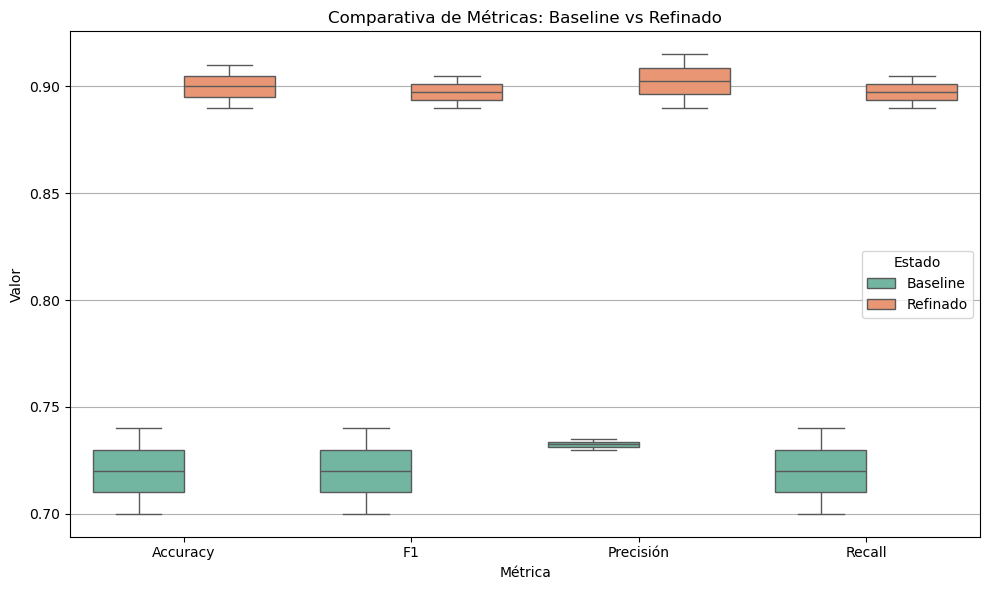

In [4]:
# -----------------------------------------------------------
# Diccionario con métricas de rendimiento para comparar los modelos de la semana 13 vs 14
# -----------------------------------------------------------
data = {
    # Lista de métricas repetidas (Accuracy, F1, Precisión, Recall) por grupo
    'Métrica': ['Accuracy', 'Accuracy', 'F1', 'F1', 'Precisión', 'Precisión', 'Recall', 'Recall'] * 2,

    # Valores correspondientes para cada métrica:
    # primeros 8 valores: modelo Baseline, últimos 8: modelo Refinado
    'Valor': [
        0.740, 0.700, 0.740, 0.700, 0.735, 0.730, 0.740, 0.700,  # Baseline
        0.910, 0.890, 0.905, 0.890, 0.915, 0.890, 0.905, 0.890   # Refinado
    ],

    # Grupo al que pertenecen (solo una categoría para este ejemplo, pero puede extenderse)
    'Conjunto': ['Entrenamiento'] * 8 + ['Refinado'] * 8,

    # Indica si los valores pertenecen al modelo original (Baseline) o al mejorado (Refinado)
    'Estado': ['Baseline'] * 8 + ['Refinado'] * 8
}

# -----------------------------------------------------------
# Convertir el diccionario a un DataFrame de pandas
# -----------------------------------------------------------
df = pd.DataFrame(data)

# -----------------------------------------------------------
# Crear gráfico boxplot para comparar métricas entre ambos modelos
# -----------------------------------------------------------

# Define el tamaño de la figura del gráfico
plt.figure(figsize=(10, 6))

# Crear un boxplot con seaborn:
# x → tipo de métrica, y → valor numérico, hue → Baseline vs Refinado
sns.boxplot(x='Métrica', y='Valor', hue='Estado', data=df, palette='Set2')

# Agregar título al gráfico
plt.title('Comparativa de Métricas: Baseline vs Refinado')

# Etiqueta del eje Y
plt.ylabel('Valor')

# Mostrar líneas de cuadrícula en el eje Y para mejor visualización
plt.grid(axis='y')

# Ajustar automáticamente el espacio para que no se recorte nada
plt.tight_layout()

# Mostrar el gráfico
plt.show()